In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pydst
import ipywidgets as widgets
from matplotlib import pyplot as plt
import scipy.stats
import tkinter as tk
import tkinter as tk

Dst = pydst.Dst(lang='en')

In [2]:
account = Dst.get_data(table_id = "REGK11", variables = {"OMRÅDE": ["*"], "FUNK1": ["X"], "DRANST": ["1"], "ART": ["TOT"], "PRISENHED": ["INDL"], "Tid": ["*"]})
budget = Dst.get_data(table_id = "BUDK1", variables = {"REGI07A": ["*"], "FUNK1": ["X"], "DRANST": ["1"], "ART": ["TOT"], "PRISENHED": ["INDL"], "Tid": ["*"]})
people = Dst.get_data(table_id = "INDAMP01", variables = {"OMRÅDE": ["*"], "KØN": ["TOT"], "ALDER": ["TOT"], "PERSG": ["IALT"], "Tid": ["*"], "BNØGLE": ["PER"]})

account.head()

,OMRÅDE,FUNK1,DRANST,ART,PRISENHED,TID,INDHOLD
0,Hillerød,Total main account 0-6,1 Current expenditure,Total,"Per capita, current prices (DKK)",2012,62180
1,Solrød,Total main account 0-6,1 Current expenditure,Total,"Per capita, current prices (DKK)",2012,53166
2,Dragør,Total main account 0-6,1 Current expenditure,Total,"Per capita, current prices (DKK)",2012,53794
3,Gribskov,Total main account 0-6,1 Current expenditure,Total,"Per capita, current prices (DKK)",2012,61529
4,Gentofte,Total main account 0-6,1 Current expenditure,Total,"Per capita, current prices (DKK)",2012,54695


account har årene 2011-2018

budget har årene 2009-2019

people har årene 2006-2017

In [3]:
account.drop(["FUNK1", "DRANST", "ART", "PRISENHED"], axis=1, inplace=True)
budget.drop(["FUNK1", "DRANST", "ART", "PRISENHED"], axis=1, inplace=True)
people.drop(["KØN", "ALDER", "PERSG", "BNØGLE"], axis=1, inplace=True)

account.head()

,OMRÅDE,TID,INDHOLD
0,Hillerød,2012,62180
1,Solrød,2012,53166
2,Dragør,2012,53794
3,Gribskov,2012,61529
4,Gentofte,2012,54695


In [4]:
budget.rename(columns = {"REGI07A":"Municipality", "TID": "Year", "INDHOLD":"Budget"}, inplace = True)
account.rename(columns = {"OMRÅDE":"Municipality", "TID": "Year", "INDHOLD":"Account"}, inplace = True)
people.rename(columns = {"OMRÅDE":"Municipality", "TID": "Year", "INDHOLD":"People"}, inplace = True)

account.head()

,Municipality,Year,Account
0,Hillerød,2012,62180
1,Solrød,2012,53166
2,Dragør,2012,53794
3,Gribskov,2012,61529
4,Gentofte,2012,54695


In [5]:
for val in ["Region", "Province", "All Denmark"]:
    for count, dataset in enumerate([people, budget, account]):
        rowstodrop = dataset.loc[lambda df: df["Municipality"].str.contains(val)].index
        dataset.drop(rowstodrop, axis=0, inplace=True)

a = []
for i in range(2011,2018):
    a.append(str(i))

budget = budget.loc[budget["Year"].isin(a)]
people = people.loc[people["Year"].isin(a)]
account = account.loc[account["Year"].isin(a)]

account.head()

,Municipality,Year,Account
0,Hillerød,2012,62180
1,Solrød,2012,53166
2,Dragør,2012,53794
3,Gribskov,2012,61529
4,Gentofte,2012,54695


In [6]:
partialmerge = pd.merge(people, account, how="outer", on=["Municipality", "Year"])
fullymerged = pd.merge(partialmerge, budget, how="outer", on=["Municipality", "Year"])
fullymerged.head()

,Municipality,Year,People,Account,Budget
0,Holbæk,2011,69521,61203,61099
1,Faxe,2011,35277,59814,59963
2,Kalundborg,2011,49088,66668,66307
3,Ringsted,2011,32890,61444,62650
4,Slagelse,2011,77442,63393,63924


In [7]:
fullymerged["Surplus"] = fullymerged["Budget"]-fullymerged["Account"]
fullymerged[fullymerged["Municipality"]=="Langeland"].head()

,Municipality,Year,People,Account,Budget,Surplus
21,Langeland,2011,13322,75910,76678,768
119,Langeland,2012,13094,80882,82363,1481
217,Langeland,2013,12861,76382,84904,8522
348,Langeland,2014,12695,74942,79910,4968
446,Langeland,2015,12647,74794,77874,3080


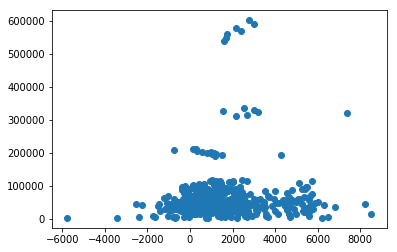

In [8]:
plt.scatter(fullymerged["Surplus"], fullymerged["People"])
plt.show()

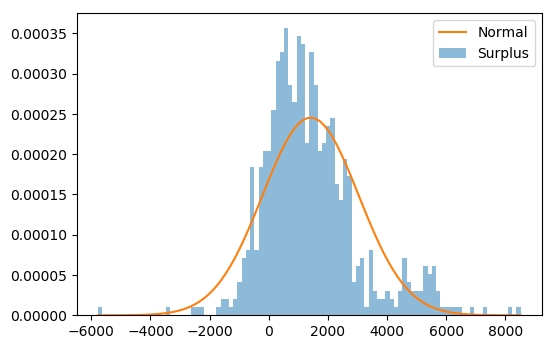

In [9]:
mean = np.mean(fullymerged["Surplus"])
variance = np.var(fullymerged["Surplus"])
sigma = np.sqrt(variance)

x = np.linspace(min(fullymerged["Surplus"]), max(fullymerged["Surplus"]), 100)


fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.hist(fullymerged["Surplus"], density=True, bins = 100, alpha = 0.5, label = "Surplus")
ax.plot(x, scipy.stats.norm.pdf(x, mean, sigma), label = "Normal")
ax.legend()

In [10]:
from NokiaSnakeClient import graphwindow   

app = graphwindow(data=fullymerged, x="Year",y="Surplus",y2="People",graphnames="Municipality")
app.geometry("1280x720")
app.mainloop()

In [11]:
help(graphwindow)

Help on class graphwindow in module NokiaSnakeClient:

class graphwindow(tkinter.Tk)
 |  graphwindow(data, x, y, y2, graphnames, **kwargs)
 |  
 |  Toplevel widget of Tk which represents mostly the main window
 |  of an application. It has an associated Tcl interpreter.
 |  
 |  Method resolution order:
 |      graphwindow
 |      tkinter.Tk
 |      tkinter.Misc
 |      tkinter.Wm
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data, x, y, y2, graphnames, **kwargs)
 |      Return a new Toplevel widget on screen SCREENNAME. A new Tcl interpreter will
 |      be created. BASENAME will be used for the identification of the profile file (see
 |      readprofile).
 |      It is constructed from sys.argv[0] without extensions if None is given. CLASSNAME
 |      is the name of the widget class.
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from tkinter.Tk:
 |  
 |  __getattr__(self, attr)
 |      Delegate a

In [ ]:
def plot_e(dataframe, municipality): 
    I = dataframe['Municipality'] == municipality
    ax = dataframe.loc[I,:]
    
    
    ax.plot(x='Year', y="Surplus", style='-o', color="#00FF00", legend='False')
    ax.plot(x='Year', y="People", style='-o', legend='False')
    
widgets.interact(plot_e, 
    dataframe = widgets.fixed(fullymerged),
    municipality = widgets.Dropdown(description='Municipality', options=sorted(fullymerged.Municipality.unique()))
); 